# **Assignment 4. EuroSAT Land Use and Land Cover Classification**#

In this notebook, increasingly complex deep learning models are implementated to identify land use and land cover classifications on the [EuroSAT dataset](https://github.com/phelber/eurosat), a collection of 27,000 Sentinel-2 satellite images consisting of 13 spectral bands and 10 pre-labeled classes (e.g., Highway, AnnualCrop, River, Residential).[1][2]

**[1]** Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.

**[2]** Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.



## **Part A. Data Preprocessing**

- Mount Google Drive and install the Python package Rasterio that can access to geospatial raster data

- Download data from the Eurosat page: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

### **Step 1. Mount Google Drive and install the Python package Rasterio**

In [1]:
# Mount your Google Dirve
from google.colab import drive
drive.mount('/content/drive')

# Install Rasterio
!pip install rasterio

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.0 MB/s eta 0:00:00


### **Step 2. Import related packages for image processing and deep learning model**

In [2]:
# Packages for image reading and processing
import requests  #A HTTP package for Python
import zipfile  #A zip package (craete, read, write, append a ZIP file) for Python
import io #Python package for text I/O, binary I/O and raw I/O

from PIL import Image #PIL (Python Imaging Library): image processing
from skimage.color import rgb2gray  #Collection of algorithms for image procssing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import rasterio
from rasterio.plot import show, show_hist

# Tensor processing
import numpy as np
import os
from sklearn.utils import shuffle   # sklearn: machine learning package
from sklearn.preprocessing import LabelBinarizer

# Plotting
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Deep learning modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd #pandas: data analysis package

batch_size=16
epochs=10

### **Step 3. Download and read RGB EuroSAT images from URL**


In [3]:
# RGB file URL
url="http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r=requests.get(url)
z=zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles=[]
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles=[x for x in txtfiles if ".jpg" in x]

# read images to numpy array
XImages=np.zeros([len(txtfiles), 64, 64, 3])

i=0
for pic in txtfiles:
  #Image.open() is an image opening function in the PIL module 'Image'
  XImages[i]=np.asarray(Image.open(z.open(pic))).astype('uint8')/255  #normalize image from [0, 255] to [0.0, 1.0]
  i+=1

print("The number of image:", i)
print("The shape of XImages:", XImages.shape)
del r # clear memory
del z

The number of image: 27000
The shape of XImages: (27000, 64, 64, 3)


### **Step 4. Show the downloaded images**

[[[0.21176471 0.29803922 0.35294118]
  [0.21176471 0.29803922 0.35294118]
  [0.18823529 0.2627451  0.32941176]
  ...
  [0.32941176 0.36470588 0.39215686]
  [0.21960784 0.30980392 0.33333333]
  [0.18823529 0.30196078 0.3254902 ]]

 [[0.21960784 0.29019608 0.34509804]
  [0.22352941 0.29411765 0.34901961]
  [0.18823529 0.2627451  0.32156863]
  ...
  [0.31764706 0.36862745 0.4       ]
  [0.21568627 0.31372549 0.33333333]
  [0.18823529 0.30196078 0.3254902 ]]

 [[0.30196078 0.35294118 0.38823529]
  [0.29803922 0.35294118 0.38823529]
  [0.25490196 0.31764706 0.36862745]
  ...
  [0.23137255 0.32156863 0.34509804]
  [0.2        0.30588235 0.33333333]
  [0.19215686 0.30980392 0.34117647]]

 ...

 [[0.21568627 0.30588235 0.32941176]
  [0.21568627 0.30588235 0.32941176]
  [0.22745098 0.31764706 0.34117647]
  ...
  [0.28235294 0.36078431 0.36470588]
  [0.34509804 0.4        0.40392157]
  [0.32156863 0.36862745 0.36862745]]

 [[0.23529412 0.33333333 0.34901961]
  [0.23529412 0.33333333 0.34901961]


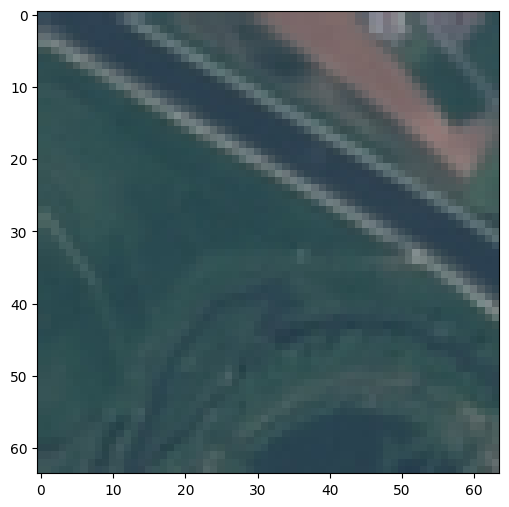

In [4]:
def plot_image(image):
  fig,ax=plt.subplots(figsize=(6,6))
  ax.imshow(image)
  plt.show()

# Call plot_image() to display an image
print(XImages[0])
plot_image(XImages[0])

### **Step 5. Get image lables**

In [5]:
# Get labels in numpy array as strings
# Example: Extract "River" from "2750/River/River_479.jpg"
labs=np.empty(len(txtfiles), dtype='S20')
i=0
for label in txtfiles:
  labs[i]=label.split('/')[1]
  i+=1

print(labs)
print(labs.shape)


'''
What does this b character in front of the string mean?

Ans. Python 3.x makes a clear distinction between the types:
-- str = '...'
-- bytes = b'...'
'''

# Change them to integers in alphabetical order

# unique()returns the sorted unique elements of an array;
# return_inverse: if true, return the indices of the unique array that can be used to reconstruct array
label_names,yLabels=np.unique(labs, return_inverse=True)

print("the shape of the label_names:", label_names.shape)
print("label_names:", label_names)
print()
print("the shape of the yLables:", yLabels.shape)
print()

label_Dict=dict(zip(np.unique(yLabels), label_names)) #create a dict: (yLabels, label_names)
print("label_Dict:",label_Dict)
print("\n")
np.array(np.unique(yLabels, return_counts=True)).T

[b'River' b'River' b'River' ... b'PermanentCrop' b'PermanentCrop'
 b'PermanentCrop']
(27000,)
the shape of the label_names: (10,)
label_names: [b'AnnualCrop' b'Forest' b'HerbaceousVegetation' b'Highway' b'Industrial'
 b'Pasture' b'PermanentCrop' b'Residential' b'River' b'SeaLake']

the shape of the yLables: (27000,)

label_Dict: {0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}




array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

### **Step 6. Show the processed images and labels**

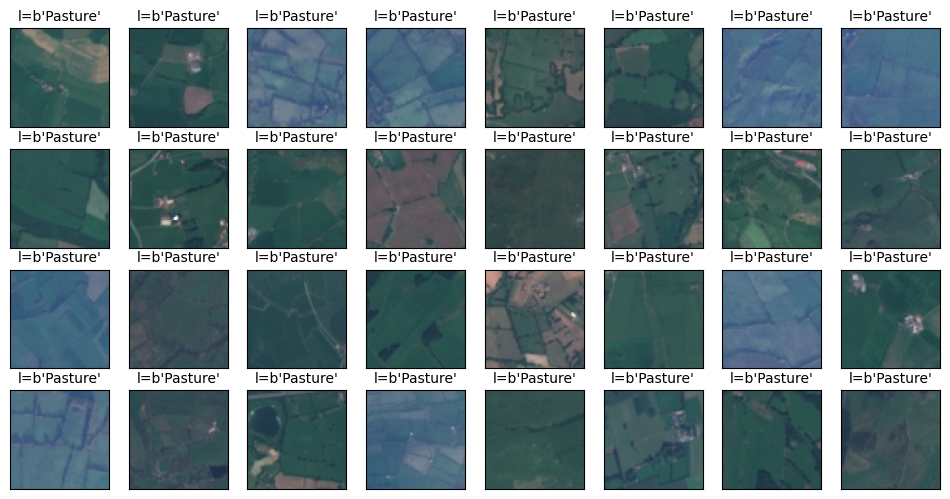

In [6]:
# Test that the labels and images read in properly
def plot_multiimages(images,labels,prediction,idx,num=32):
  fig,ax=plt.subplots(4,8,figsize=(12,6))
  if num>32:num=32 # if the number of images > 32，then set to 32 to avoid errors
  for i in range(0,num):
    ax=plt.subplot(4,8,1+i) # Build 4x8 subgraphs
    ax.imshow(images[idx],cmap='binary')
    if len(prediction)>0:
      title="l={},p={}".format(str(label_names[labels[idx]]),str(prediction[idx]))
    else:
      title="l={}".format(str(label_names[labels[idx]]))
    ax.set_title(title,fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    idx+=1 # read the next image
  plt.show()

plot_multiimages(XImages,yLabels,[],18000,32)

### **Step 7. Shuffle the datasets and balance the labels**

In [7]:
# find the smallest class
smallest_class=np.argmin(np.bincount(yLabels))
print("The class index of the smallest class:",smallest_class, label_names[smallest_class])

# number of classes
num_classes=len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs=np.where(yLabels==smallest_class)[0]

# Get 2000 observations from each class
indBal=np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp=shuffle(np.where(yLabels==i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal=np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal=shuffle(indBal, random_state=42)

yBal=yLabels[indBal]
XBal=XImages[indBal]

print(yBal.shape)
print(XBal.shape)

The class index of the smallest class: 5 b'Pasture'
(20000,)
(20000, 64, 64, 3)


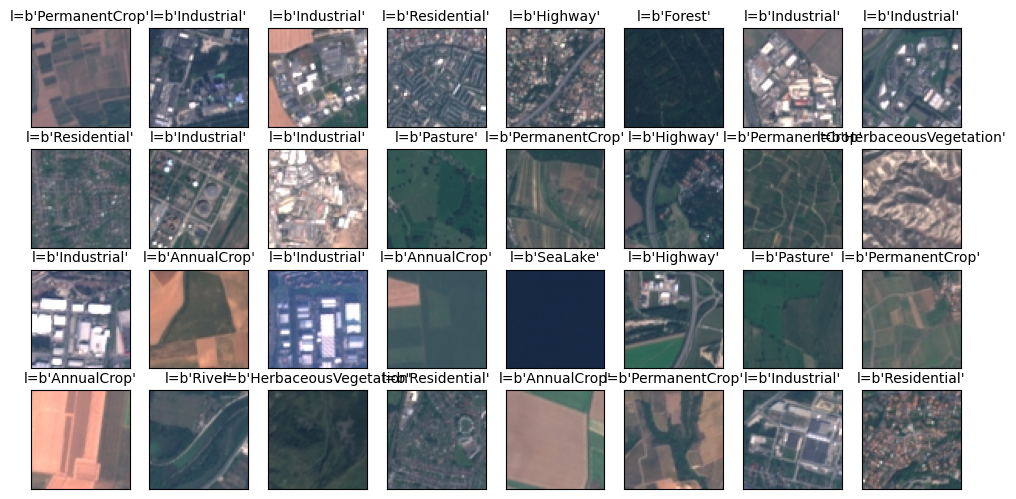

In [8]:
# first line uses balanced labels
# second line uses original imbalanced labels

# X_train, X_test, y_train, y_test=train_test_split(XBal, yBal, stratify=yBal, train_size=0.5, random_state=42)
X_train,X_test,y_train,y_test=train_test_split(XImages, yLabels, stratify=yLabels, train_size=0.5, random_state=42)

# Test that the labels and images are still matched up properly
plot_multiimages(X_train,y_train,[],300,32)

In [9]:
# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

# convert class vectors to binary class matrices
y_train=tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test=tensorflow.keras.utils.to_categorical(y_test, num_classes)

### **Part B. Model 1**

- Convert each RBG image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)

- Implement a first deep learning model `M1` using a fully connected network with a single dense layer.

- **Classification accuracy on the test data.** 26.0%

This model does not include any spatial information (i.e., pixels don't have any information about neighboring pixels).

In [10]:
# Initialize grayscale arrays
X_train_BW=np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])

X_test_BW=np.zeros([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i]=rgb2gray(X_train[i])
  X_test_BW[i]=rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW=X_train_BW.reshape(X_train_BW.shape[0], X_train_BW.shape[1]*X_train_BW.shape[2])

X_test_BW=X_test_BW.reshape(X_test_BW.shape[0], X_test_BW.shape[1]*X_test_BW.shape[2])

print("X_train_BW shape:" + str(X_train_BW.shape))
print("X_test_BW shape:" + str(X_test_BW.shape))
print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))

X_train_BW shape:(13500, 4096)
X_test_BW shape:(13500, 4096)
y_train shape:(13500, 10)
y_test shape:(13500, 10)


Implement first deep learning model

In [85]:
# save model to here
model_file='/content/drive/MyDrive/liu/Models/M1.h5.keras'

checkpoint=ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                     │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,970 (160.04 KB)

 Trainable params: 40,970 (160.04 KB)

 Non-trainable params: 0 (0.00 B)

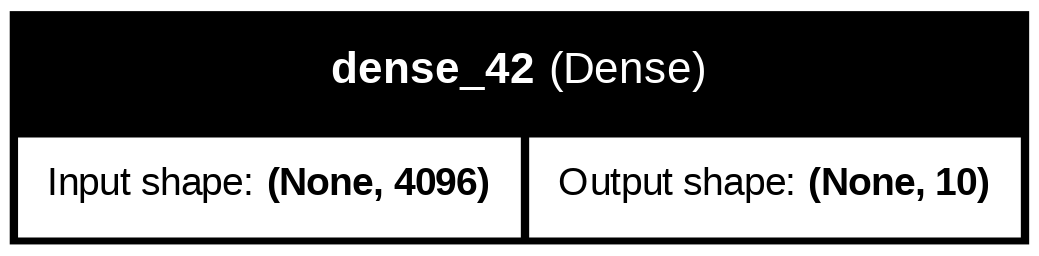

In [86]:
M1=Sequential()
M1.add(Dense(num_classes, activation='softmax', input_shape=(4096,)))
M1.summary()

plot_model(M1, show_shapes=True, show_layer_names=True)

In [87]:
M1.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

train_history_M1=M1.fit(X_train_BW, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
               callbacks=callback_list, validation_data=(X_test_BW,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1195 - loss: 2.5062 - val_accuracy: 0.1601 - val_loss: 2.3149
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1724 - loss: 2.3658 - val_accuracy: 0.1586 - val_loss: 2.3668
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1838 - loss: 2.3291 - val_accuracy: 0.2542 - val_loss: 2.3560
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2074 - loss: 2.3074 - val_accuracy: 0.2253 - val_loss: 2.4335
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2328 - loss: 2.2262 - val_accuracy: 0.1765 - val_loss: 2.2303
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2489 - loss: 2.1849 - val_accuracy: 0.1924 - val_loss: 2.2215
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2405 - loss: 2.1857 - val_accuracy: 0.2318 - val_loss: 2.1624
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2515 - loss: 2.1774 - val_accuracy: 0.

In [88]:
score=M1.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Test loss: 2.240665912628174
Test accuracy: 0.19066666066646576


In [11]:
def show_train_history(train_history,train,validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel(train)
  plt.xlabel('Epoch')
  plt.legend(['train','validation'],loc='upper left')
  plt.show()

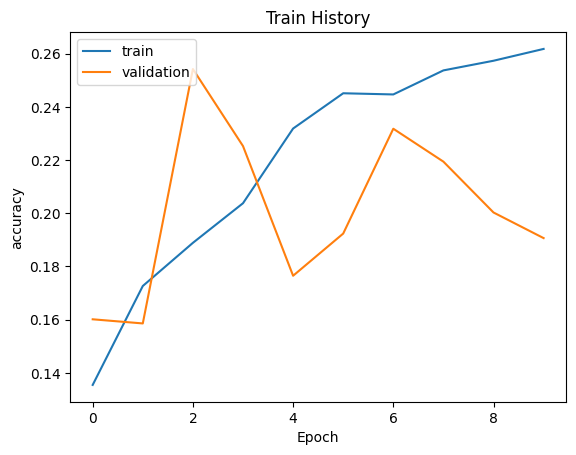

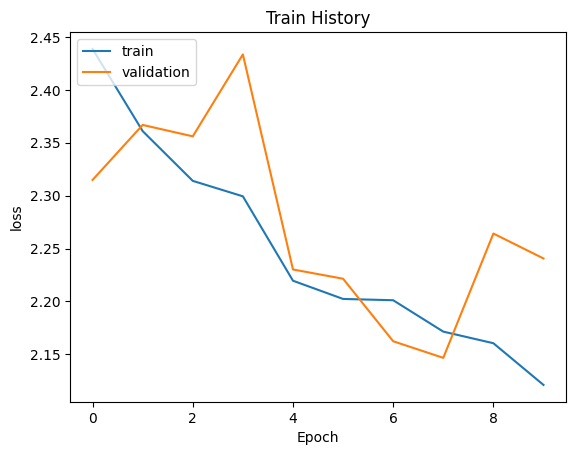

In [89]:
show_train_history(train_history_M1,'accuracy','val_accuracy')
show_train_history(train_history_M1,'loss','val_loss')

In [19]:
y_test_true_tmp=np.argmax(y_test, axis=1)
label_count=np.unique(y_test_true_tmp, return_counts=True)[1]

In [12]:
# Define functions for evaluating model accuracy by class and overall
def eval_model_by_class(model, test_set):
  y_test_pred_tmp=np.argmax(model.predict(test_set),axis=-1)

  y_test_true=[label_Dict[x] for x in y_test_true_tmp]
  y_test_pred=[label_Dict[x] for x in y_test_pred_tmp]

  pred_df=pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds']=pred_df.y_true==pred_df.y_pred
  pred_df=pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count']=label_count
  pred_df['class_acc']=pred_df.accurate_preds/pred_df.label_count
  pred_df=pred_df.sort_values(by='class_acc').reset_index()
  pred_df['overall_acc']=sum(pred_df.accurate_preds)/sum(pred_df.label_count)
  pred_df=pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred_tmp=np.argmax(model.predict(test_set),axis=-1)

  y_test_true=[label_Dict[x] for x in y_test_true_tmp]
  y_test_pred=[label_Dict[x] for x in y_test_pred_tmp]

  pred_df=pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds']=pred_df.y_true==pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df=pred_df.sort_values('y_true')

  return(pred_df)

In [90]:
M1_pred_df=eval_model_by_class(M1, X_test_BW)
M1_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'ResidentialRiverRiverRiverResidentialResiden...,14,1500,0.009333,0.190667
1,1,b'Forest',b'RiverRiverRiverRiverSeaLakeSeaLakeRiverRiver...,15,1500,0.010000,0.190667
2,2,b'HerbaceousVegetation',b'RiverResidentialRiverRiverResidentialIndustr...,0,1500,0.000000,0.190667
3,3,b'Highway',b'ResidentialIndustrialResidentialRiverRiverRi...,29,1250,0.023200,0.190667
4,4,b'Industrial',b'IndustrialAnnualCropIndustrialIndustrialIndu...,847,1250,0.677600,0.190667
5,5,b'Pasture',b'ResidentialRiverRiverRiverResidentialRiverRi...,0,1000,0.000000,0.190667
6,6,b'PermanentCrop',b'RiverIndustrialRiverIndustrialHighwayResiden...,1,1250,0.000800,0.190667
7,7,b'Residential',b'RiverRiverRiverRiverRiverRiverIndustrialRive...,399,1500,0.266000,0.190667
8,8,b'River',b'RiverRiverRiverRiverRiverRiverSeaLakeRiverRi...,975,1250,0.780000,0.190667
9,9,b'SeaLake',b'RiverResidentialSeaLakeForestRiverSeaLakeFor...,294,1500,0.196000,0.190667


### **Part B. Model 2**

- Implement a second deep learning model `M2` adding an additional dense layer to the previous model.

- **Classification accuracy on the test data.** 26.7%

In [91]:
model_file='/content/drive/MyDrive/liu/Models/M2.h5.keras'

checkpoint=ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                     │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,051,402 (4.01 MB)

 Trainable params: 1,051,402 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

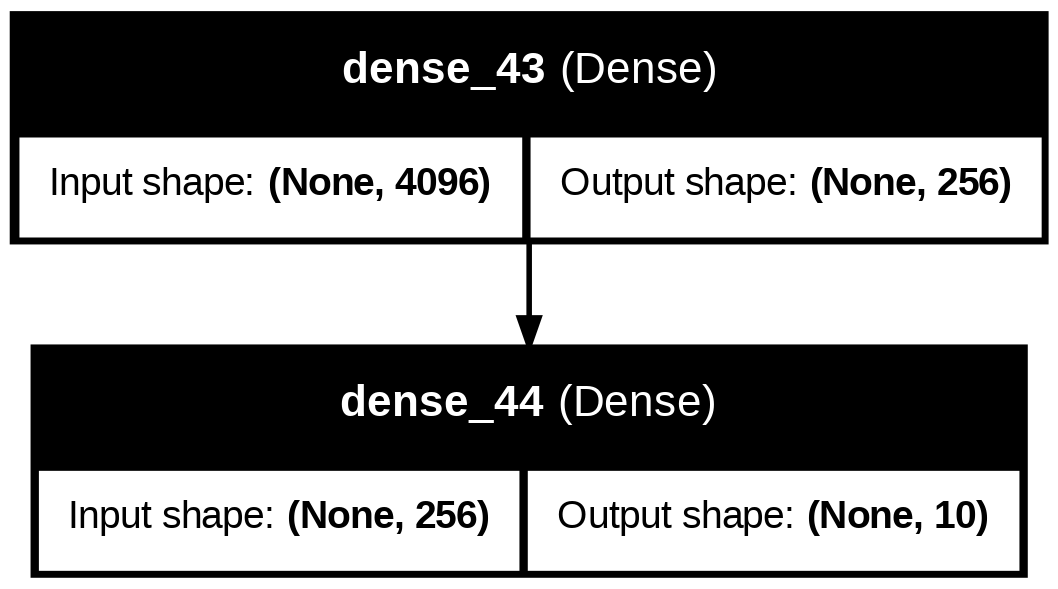

In [92]:
M2=Sequential()
M2.add(Dense(256, activation='relu', input_shape=(4096,)))
M2.add(Dense(num_classes, activation='softmax'))

M2.summary()
plot_model(M2, show_shapes=True, show_layer_names=True)

In [93]:
M2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
train_history_M2=M2.fit(X_train_BW, y_train, batch_size=batch_size, epochs=epochs,
               callbacks=callback_list, verbose=1, validation_data=(X_test_BW,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1318 - loss: 2.4271 - val_accuracy: 0.1904 - val_loss: 2.1841
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1885 - loss: 2.1751 - val_accuracy: 0.2088 - val_loss: 2.1200
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2312 - loss: 2.1165 - val_accuracy: 0.2813 - val_loss: 2.0916
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2511 - loss: 2.0925 - val_accuracy: 0.2599 - val_loss: 2.0591
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2666 - loss: 2.0417 - val_accuracy: 0.2614 - val_loss: 2.0567
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2700 - loss: 2.0069 - val_accuracy: 0.2599 - val_loss: 1.9969
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2748 - loss: 1.9748 - val_accuracy: 0.2480 - val_loss: 1.9949
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2851 - loss: 1.9325 - val_accuracy: 0.

Test loss: 1.9069257974624634
Test accuracy: 0.30000001192092896


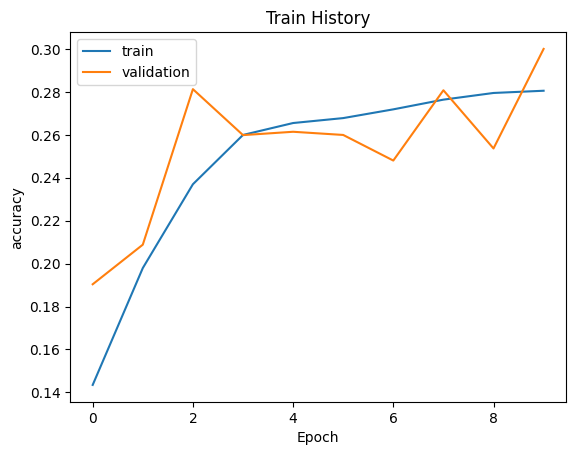

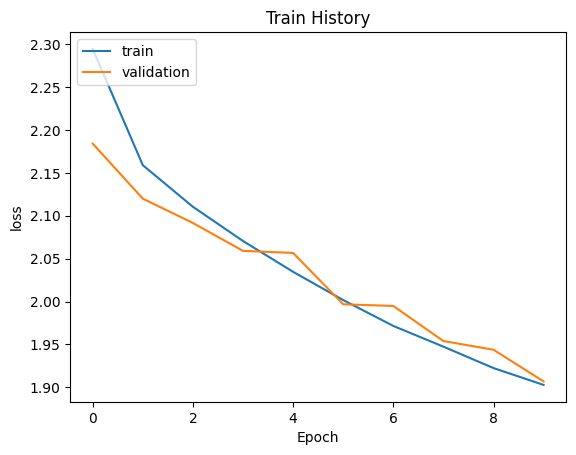

In [94]:
score=M2.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M2,'accuracy','val_accuracy')
show_train_history(train_history_M2,'loss','val_loss')

In [95]:
M2_pred_df=eval_model_by_class(M2, X_test_BW)
M2_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'AnnualCropRiverAnnualCropAnnualCropAnnualCro...,867,1500,0.578000,0.3
1,1,b'Forest',b'ForestSeaLakeForestHerbaceousVegetationFores...,1117,1500,0.744667,0.3
2,2,b'HerbaceousVegetation',b'AnnualCropAnnualCropAnnualCropAnnualCropResi...,191,1500,0.127333,0.3
3,3,b'Highway',b'AnnualCropResidentialAnnualCropAnnualCropRiv...,0,1250,0.000000,0.3
4,4,b'Industrial',b'IndustrialAnnualCropIndustrialIndustrialIndu...,852,1250,0.681600,0.3
5,5,b'Pasture',b'HerbaceousVegetationAnnualCropRiverSeaLakeSe...,0,1000,0.000000,0.3
6,6,b'PermanentCrop',b'AnnualCropIndustrialAnnualCropAnnualCropAnnu...,0,1250,0.000000,0.3
7,7,b'Residential',b'RiverResidentialResidentialRiverAnnualCropHe...,318,1500,0.212000,0.3
8,8,b'River',b'RiverRiverSeaLakeRiverRiverRiverSeaLakeSeaLa...,480,1250,0.384000,0.3
9,9,b'SeaLake',b'ForestAnnualCropForestForestHerbaceousVegeta...,225,1500,0.150000,0.3


### **Part B. Model 3**

- Implement a third deep learning model `M3` adding two additional dense layers as well as drop-out layers to the previous model.

- **Classification accuracy on the test data.** 11.1%
- **Compare against previous models. Which model was the "best"? Why?** Of the first three models, `M2` was the best. It had a higher accuracy on the test data, and based on the plots showing training/testing loss and accuracy, it fit the data better than either Models M1 or M3, which both showed large fluctuations in the testing loss and accuracy.

In [96]:
model_file='/content/drive/MyDrive/liu/Models/M3.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,182,986 (4.51 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

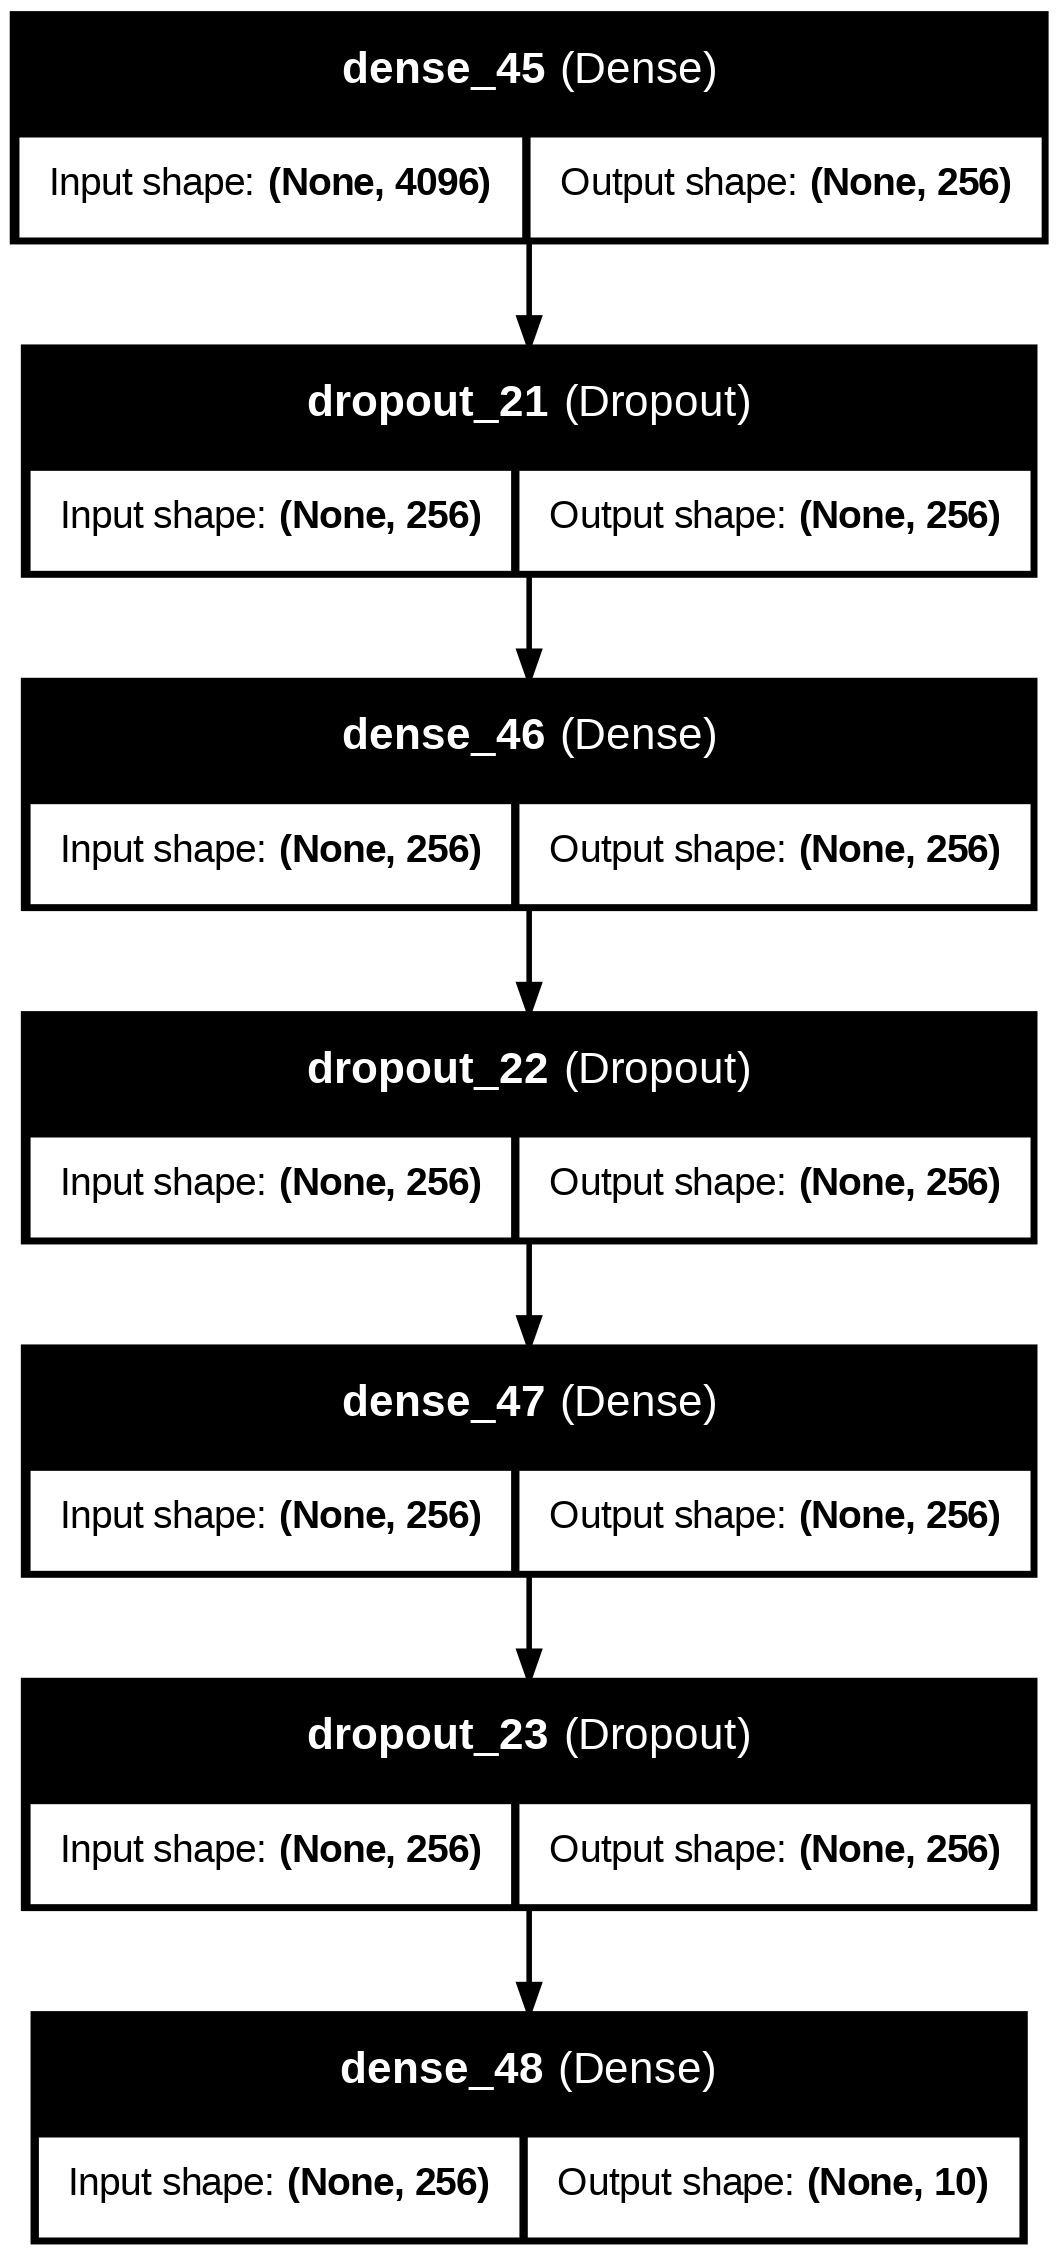

In [97]:
M3=Sequential()
M3.add(Dense(256, activation='relu', input_shape=(4096,)))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(num_classes, activation='softmax'))

M3.summary()

plot_model(M3, show_shapes=True, show_layer_names=True)

In [98]:
M3.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

train_history_M3=M3.fit(X_train_BW, y_train, batch_size=batch_size, epochs=epochs,
               callbacks=callback_list, verbose=1, validation_data=(X_test_BW,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1103 - loss: 2.3603 - val_accuracy: 0.1111 - val_loss: 2.2956
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1096 - loss: 2.2964 - val_accuracy: 0.1111 - val_loss: 2.2952
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1076 - loss: 2.2969 - val_accuracy: 0.1111 - val_loss: 2.2951
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1104 - loss: 2.2970 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1067 - loss: 2.2953 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1119 - loss: 2.2945 - val_accuracy: 0.1111 - val_loss: 2.2950
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1083 - loss: 2.2963 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1112 - loss: 2.2974 - val_accuracy: 0

Test loss: 2.2948124408721924
Test accuracy: 0.1111111119389534


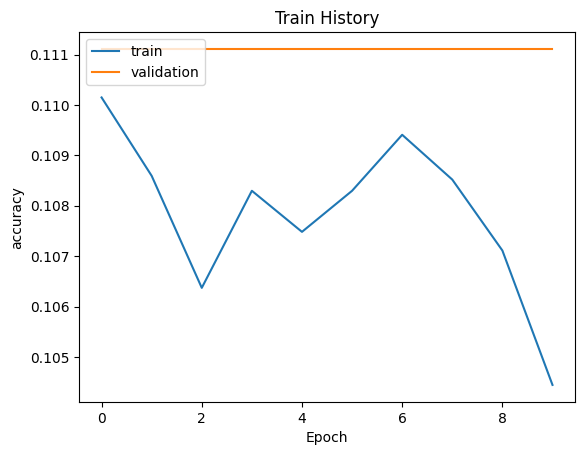

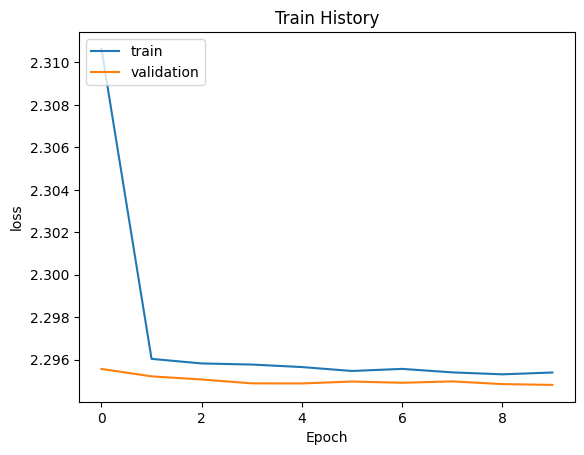

In [99]:
score=M3.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M3,'accuracy','val_accuracy')
show_train_history(train_history_M3,'loss','val_loss')

In [100]:
M3_pred_df=eval_model_by_class(M3, X_test_BW)
M3_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111
1,1,b'Forest',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111
2,2,b'HerbaceousVegetation',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111
3,3,b'Highway',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
4,4,b'Industrial',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
5,5,b'Pasture',b'ResidentialResidentialResidentialResidential...,0,1000,0.0,0.111111
6,6,b'PermanentCrop',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1500,1500,1.0,0.111111
8,8,b'River',b'ResidentialResidentialResidentialResidential...,0,1250,0.0,0.111111
9,9,b'SeaLake',b'ResidentialResidentialResidentialResidential...,0,1500,0.0,0.111111


### **Part B. Model 4**

- Using RGB images (without vectorizing them), implement a fourth model `M4` that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense.

- **Classification accuracy on the test data.** 77.6%
- **Compare against previous models. Which model was the "best"? Why?** Model `M4` is clearly the best so far, with a testing accuracy of 76.2%. The inclusion of the convolutional and maxpooling layers added a spatial component to the model, boosting the predictive power significantly. Based on the divergence of the training/testing loss and accuracy plots, the model started overfitting the training data after 10 or so epochs.

In [13]:
input_shape=X_train.shape[1:]

In [101]:
model_file='/content/drive/MyDrive/liu/Models/M4.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,767,818 (56.33 MB)

 Trainable params: 14,767,818 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

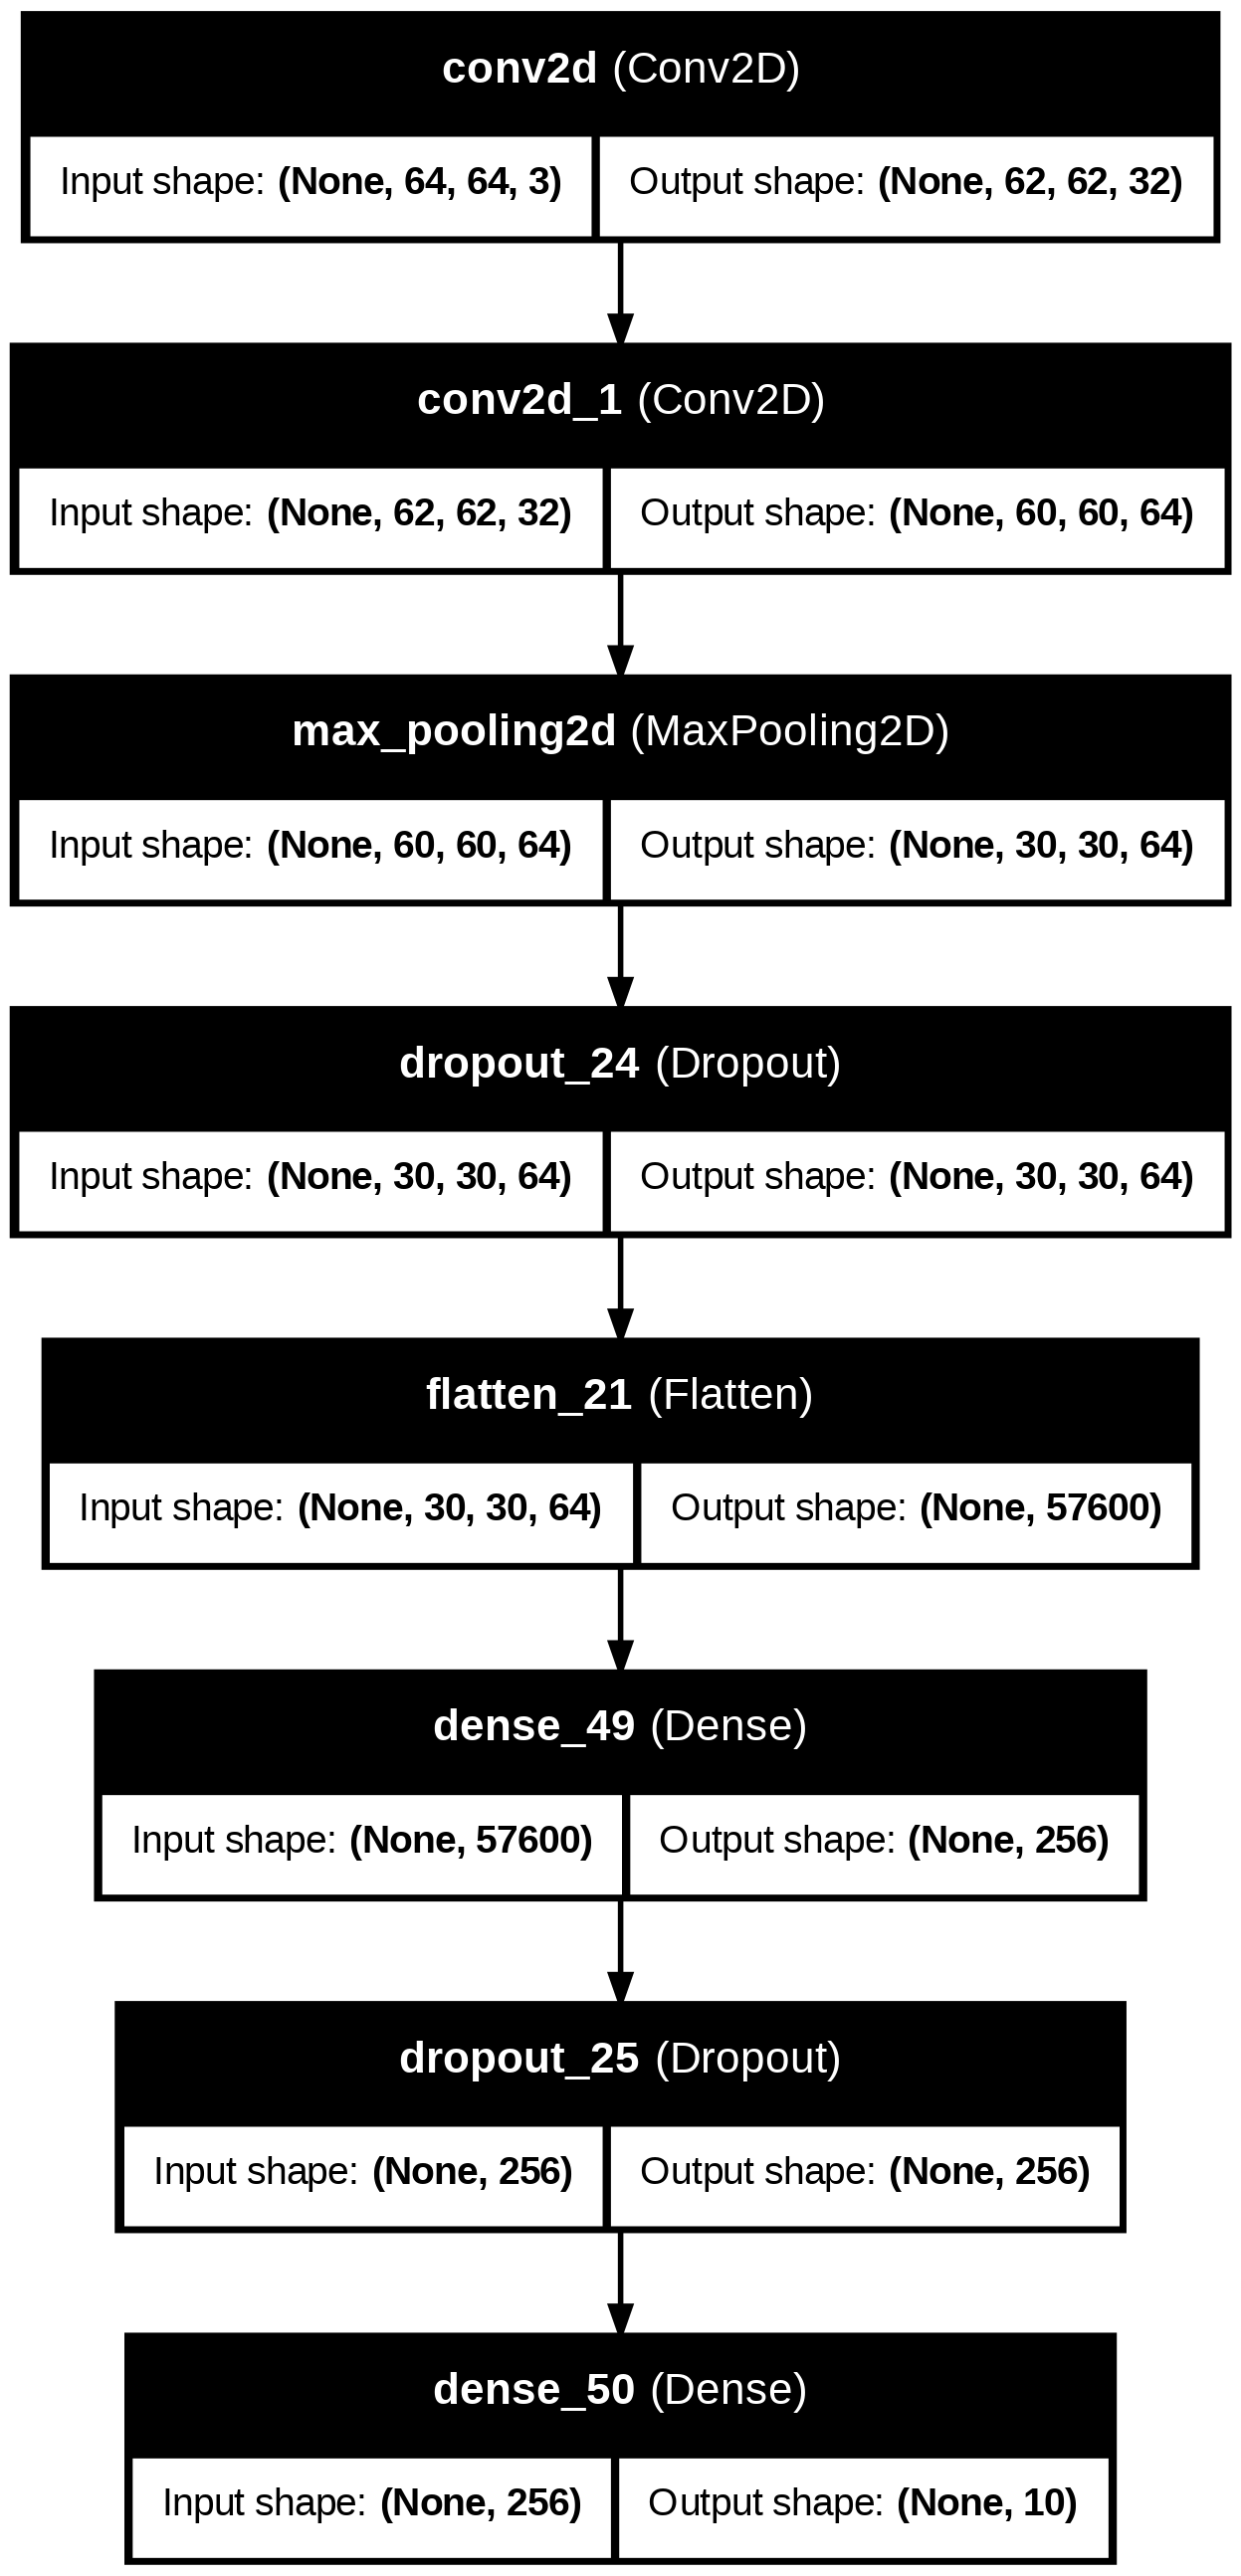

In [102]:
M4=Sequential()
M4.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
M4.add(Conv2D(64, (3,3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2,2)))
M4.add(Dropout(0.2))
M4.add(Flatten())
M4.add(Dense(256, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(num_classes, activation='softmax'))

M4.summary()

plot_model(M4,show_shapes=True,show_layer_names=True)

In [103]:
M4.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

train_history_M4=M4.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,
               callbacks=callback_list,verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3958 - loss: 1.6415 - val_accuracy: 0.6110 - val_loss: 1.0080
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6708 - loss: 0.9189 - val_accuracy: 0.7410 - val_loss: 0.7467
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7777 - loss: 0.6240 - val_accuracy: 0.7637 - val_loss: 0.6784
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8427 - loss: 0.4531 - val_accuracy: 0.7825 - val_loss: 0.6544
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8865 - loss: 0.3323 - val_accuracy: 0.7859 - val_loss: 0.7000
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9009 - loss: 0.2923 - val_accuracy: 0.7519 - val_loss: 0.9185
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9207 - loss: 0.2276 - val_accuracy: 0.7777 - val_loss: 0.8695
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9313 - loss: 0.2084 - val_accuracy: 

Test loss: 1.176111102104187
Test accuracy: 0.7620000243186951


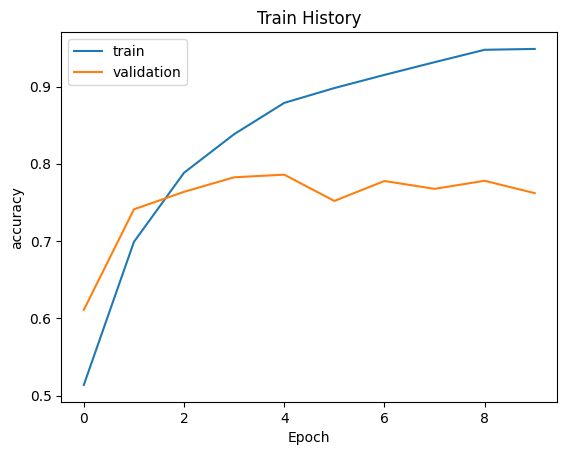

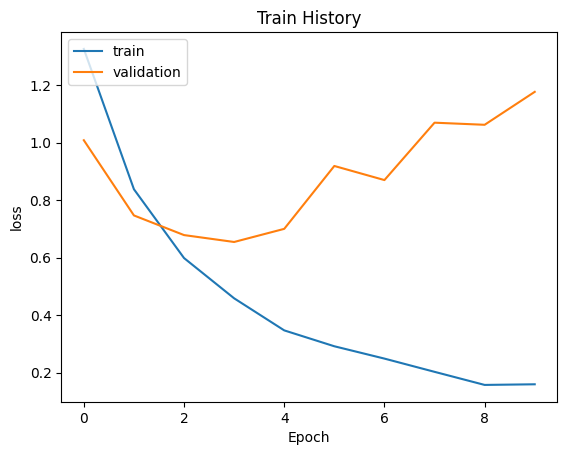

In [104]:
score=M4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M4,'accuracy','val_accuracy')
show_train_history(train_history_M4,'loss','val_loss')

In [105]:
M4_pred_df=eval_model_by_class(M4, X_test)
M4_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'HerbaceousVegetationPastureAnnualCropAnnualC...,1173,1500,0.782000,0.762
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1354,1500,0.902667,0.762
2,2,b'HerbaceousVegetation',b'PermanentCropHerbaceousVegetationHerbaceousV...,935,1500,0.623333,0.762
3,3,b'Highway',b'PermanentCropHighwayHerbaceousVegetationHerb...,680,1250,0.544000,0.762
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1188,1250,0.950400,0.762
5,5,b'Pasture',b'PermanentCropPasturePasturePasturePasturePas...,848,1000,0.848000,0.762
6,6,b'PermanentCrop',b'PermanentCropAnnualCropPermanentCropPermanen...,789,1250,0.631200,0.762
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1231,1500,0.820667,0.762
8,8,b'River',b'RiverRiverHighwayHighwayHighwayRiverRiverRiv...,669,1250,0.535200,0.762
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1420,1500,0.946667,0.762


### **Models 5-8**

- Using RGB images (without vectorizing them), implement a deep learning model targeting accuracy that will outperform all previous models.

- **Describe the model you built, and why you chose it.** I built five more models
  - _M5:_ A model with 4 convolution-maxpooling layer pairs before a dropout layer and a dense layer. I added the additional convolutions to try to extract larger features in each image.
  - _M6:_ This model is M5, but I replaced the convolutional layers with the convolutional base of the `VGG16` model instead.[3] I ran this once with the pre-loaded weights, and I ran it again with some of the convolutional layers in VGG16 unfrozen and a lower learning rate to extract some of the lower level features from the EuroSAT images. Unfreezing the weights improved the model by about 1.6 percentage points. I created this model to see (1) the effect transfer learning would have on my accuracy and (2) the improvements I could get from fine-tuning the pre-loaded weights.
  - _M7:_ This model is the same as M6 but uses training data that has been augmented through random shearing, rotating, and flipping. I wanted to see if this would improve the overfitting I'd been seeing in some of my models.
  - _M8:_ It has the same layers and data augmentation as M7, but it also includes two callbacks: `EarlyStopping` to reduce overfitting and keep the weights from the epoch with the lowest validation loss and `ReduceLROnPlateau` to decay the learning rate as validation loss improvements slow.

- **Classification accuracy on the test data.**
  - _M5:_ 85.4%
  - _M6:_ 92.1% with pre-loaded VGG16 weights and 87.2% with additional fine-tuning
  - _M7:_ 96.6%
  - _M8:_ 97.8%

- **Compare against previous models. Which model was the "best"? Why?** M8, which uses VGG16's convolutional base, augmented data, and callbacks, had the best performance. In terms of accuracy, it correctly classified 94.5% of the test set. Based on the training/testing accuracy and loss plots, the two models with callbacks clearly performed better from an overfitting perspective. The decay in the learning rate also helped the model make marginal improvements in validation loss more quickly than previous models. Lastly, EarlyStopping reduced the training time and allowed me to retain the weights from the epoch with the lowest validation loss.

- **What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.** The highest errors were in the SeaLake and AnnualCrop images, which both had accuracies in the low 90's, well below the other categories. As shown in the examples, they were most often confused with Forest and PermanentCrop/Pasture, respectively.

**[3]** Very Deep Convolutional Networks for Large-Scale Image Recognition
K. Simonyan, A. Zisserman
arXiv:1409.1556

### **Part B. Model 5**

In [106]:
model_file='/content/drive/MyDrive/liu/Models/M5.h5.keras'

checkpoint=ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

In [107]:
input_shape=X_train.shape[1:]
M5 = Sequential()
M5.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Conv2D(64, (3,3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Conv2D(128, (3,3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Conv2D(256, (3,3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2,2)))
M5.add(Flatten())
M5.add(Dropout(0.5))
M5.add(Dense(512, activation='relu'))
# M5.add(Dropout(0.2))
M5.add(Dense(num_classes, activation='softmax'))

M5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 918,346 (3.50 MB)

 Trainable params: 918,346 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
M5.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

train_history_M5=M5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              callbacks=callback_list, verbose=1, validation_data=(X_test,y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.3571 - loss: 1.6395 - val_accuracy: 0.6304 - val_loss: 0.9985
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6505 - loss: 0.9649 - val_accuracy: 0.7282 - val_loss: 0.7640
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7209 - loss: 0.7814 - val_accuracy: 0.7619 - val_loss: 0.6742
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7571 - loss: 0.6757 - val_accuracy: 0.7884 - val_loss: 0.6012
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7942 - loss: 0.5756 - val_accuracy: 0.8166 - val_loss: 0.5256
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8113 - loss: 0.5391 - val_accuracy: 0.8202 - val_loss: 0.5220
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8348 - loss: 0.4790 - val_accuracy: 0.8269 - val_loss: 0.4956
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8407 - loss: 0.4603 - val_accuracy: 

Test loss: 0.39278507232666016
Test accuracy: 0.8671851754188538


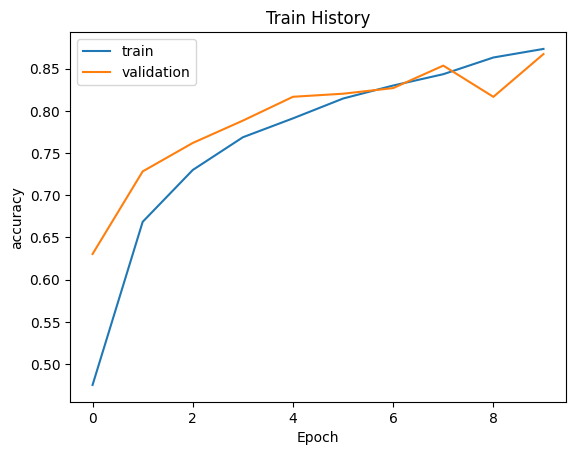

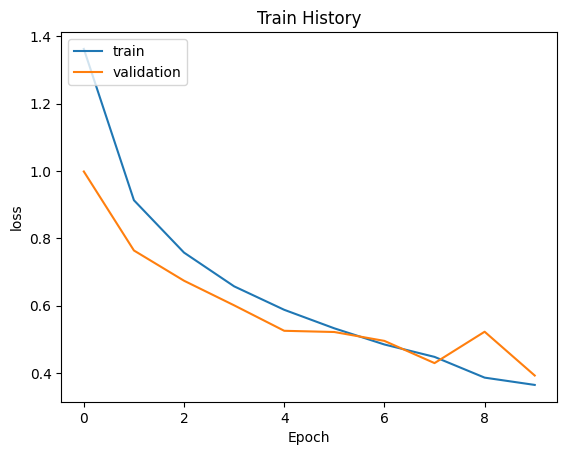

In [109]:
score=M5.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M5,'accuracy','val_accuracy')
show_train_history(train_history_M5,'loss','val_loss')

In [110]:
M5_pred_df=eval_model_by_class(M5, X_test)
M5_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'PermanentCropAnnualCropAnnualCropAnnualCropA...,1274,1500,0.849333,0.867185
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1428,1500,0.952000,0.867185
2,2,b'HerbaceousVegetation',b'PermanentCropPermanentCropHerbaceousVegetati...,1088,1500,0.725333,0.867185
3,3,b'Highway',b'PermanentCropHighwayIndustrialHighwayHighway...,1018,1250,0.814400,0.867185
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1163,1250,0.930400,0.867185
5,5,b'Pasture',b'HerbaceousVegetationPasturePasturePasturePas...,929,1000,0.929000,0.867185
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1021,1250,0.816800,0.867185
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1436,1500,0.957333,0.867185
8,8,b'River',b'RiverHighwayRiverRiverRiverRiverRiverRiverRi...,925,1250,0.740000,0.867185
9,9,b'SeaLake',b'SeaLakePastureSeaLakeSeaLakeSeaLakeSeaLakeSe...,1425,1500,0.950000,0.867185


### **Part B. Model 6:** Use `VGG16` convolutional base for Transfer Learning

In [31]:
conv_base=vgg16.VGG16(include_top=False,input_shape=input_shape)

In [32]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# how many layers are trainable in the VGG16 model?
len(conv_base.trainable_weights)

26

In [34]:
# freeze the weights
for layer in conv_base.layers:
  layer.trainable=False

In [112]:
# now there are 0
len(conv_base.trainable_weights)

1016

In [111]:
model_file='/content/drive/MyDrive/liu/Models/M6.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

In [37]:
input_shape=X_train.shape[1:]
M6=Sequential()

M6.add(Input(shape=input_shape))
M6.add(conv_base)

M6.add(Flatten())
M6.add(Dropout(0.5))
M6.add(Dense(512, activation='relu'))
M6.add(Dense(num_classes, activation='softmax'))

M6.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,768,906 (60.15 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [38]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
M6.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
train_history_M6=M6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
               callbacks=callback_list, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6128 - loss: 1.0834 - val_accuracy: 0.7868 - val_loss: 0.5916
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7656 - loss: 0.6602 - val_accuracy: 0.8075 - val_loss: 0.5331
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7852 - loss: 0.5970 - val_accuracy: 0.8019 - val_loss: 0.5434
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7995 - loss: 0.5721 - val_accuracy: 0.8200 - val_loss: 0.5191
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8014 - loss: 0.5408 - val_accuracy: 0.8376 - val_loss: 0.4621
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8158 - loss: 0.5160 - val_accuracy: 0.7994 - val_loss: 0.5449
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8231 - loss: 0.5084 - val_accuracy: 0.8255 - val_loss: 0.4893
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8273 - loss: 0.4796 - val_accuracy: 

Test loss: 0.4337579607963562
Test accuracy: 0.8470370173454285


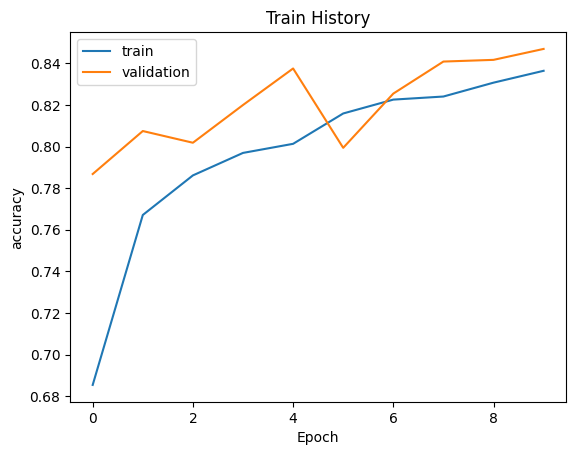

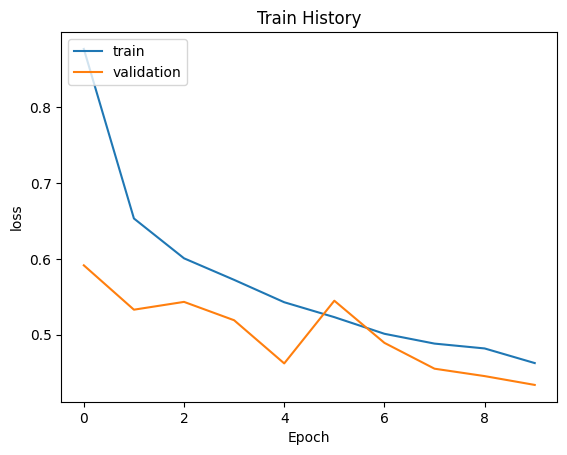

In [40]:
score=M6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M6,'accuracy','val_accuracy')
show_train_history(train_history_M6,'loss','val_loss')

**Model 6 (Part II):** Unfreeze some layers in the convolutional base

In [41]:
# how many layers are trainable in the VGG16 model?
len(conv_base.trainable_weights)

# unfreeze the latter 2/3ds of the base
for layer in conv_base.layers[7:]:
  layer.trainable = True

len(conv_base.trainable_weights)

18

In [42]:
# set a lower learning rate to minimize magnitude of changes to weights
M6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

train_history_M6=M6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
               verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6953 - loss: 0.9897 - val_accuracy: 0.9093 - val_loss: 0.2792
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8867 - loss: 0.3532 - val_accuracy: 0.9036 - val_loss: 0.3153
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9243 - loss: 0.2547 - val_accuracy: 0.8399 - val_loss: 0.4811
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9365 - loss: 0.2128 - val_accuracy: 0.9302 - val_loss: 0.2296
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9424 - loss: 0.1866 - val_accuracy: 0.9241 - val_loss: 0.2316
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9571 - loss: 0.1422 - val_accuracy: 0.9382 - val_loss: 0.1982
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9597 - loss: 0.1394 - val_accuracy: 0.9185 - val_loss: 0.2937
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9656 - loss: 0.1101 - val_accuracy: 

Test loss: 0.3062839210033417
Test accuracy: 0.9217036962509155


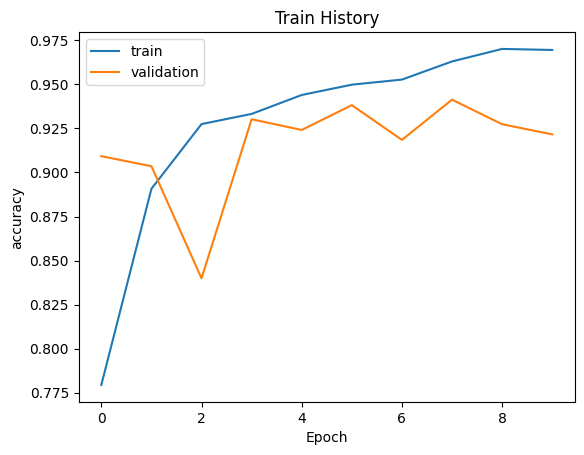

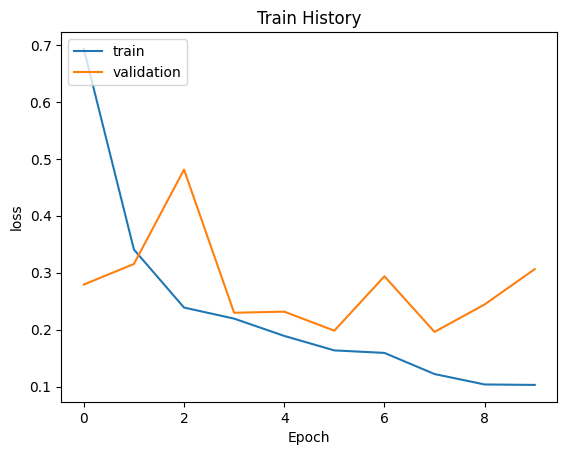

In [43]:
score=M6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M6,'accuracy','val_accuracy')
show_train_history(train_history_M6,'loss','val_loss')

In [44]:
M6_pred_df=eval_model_by_class(M6, X_test)

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


### **Part B. Model 7:** Model 6 (all trainable)+Data Augmentation

In [50]:
model_file='/content/drive/MyDrive/liu/Models/M7.h5.keras'

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True)

callback_list=[checkpoint]

In [51]:
M7=Sequential()

conv_base=vgg16.VGG16(include_top=False, input_shape=input_shape)

M7.add(conv_base)

M7.add(Flatten())
M7.add(Dropout(0.5))
M7.add(Dense(512,activation='relu'))
M7.add(Dense(num_classes,activation='softmax'))

M7.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

for layer in conv_base.layers[7:]:
  layer.trainable = True

In [52]:
train_datagen=ImageDataGenerator(
    # rescale=1. / 255,
#    shear_range=0.2,
#    zoom_range=0.2,
#    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen=ImageDataGenerator()

train_generator=train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    seed=42)

test_generator=test_datagen.flow(
    X_test,
    y_test,
    batch_size=batch_size,
    seed=42)

train_history_M7=M7.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            callbacks=callback_list,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


843/843 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5910 - loss: 1.1565 - val_accuracy: 0.8800 - val_loss: 0.4142
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7500 - loss: 0.6487

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.6487 - val_accuracy: 1.0000 - val_loss: 0.1417
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8967 - loss: 0.3473 - val_accuracy: 0.9263 - val_loss: 0.2378
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.0781 - val_accuracy: 1.0000 - val_loss: 0.0556
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9166 - loss: 0.2690 - val_accuracy: 0.9310 - val_loss: 0.2178
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.8750 - loss: 0.1793 - val_accuracy: 0.9167 - val_loss: 0.2822
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9341 - loss: 0.2181 - val_accuracy: 0.9327 - val_loss: 0.2217
Epoch 8/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.4489 - val_accuracy: 1.0000 - val_loss: 0.0185
Epoch 9/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9380 - loss: 0.1992 - val_accuracy: 0.9594 -

Test loss: 0.13194890320301056
Test accuracy: 0.9601481556892395


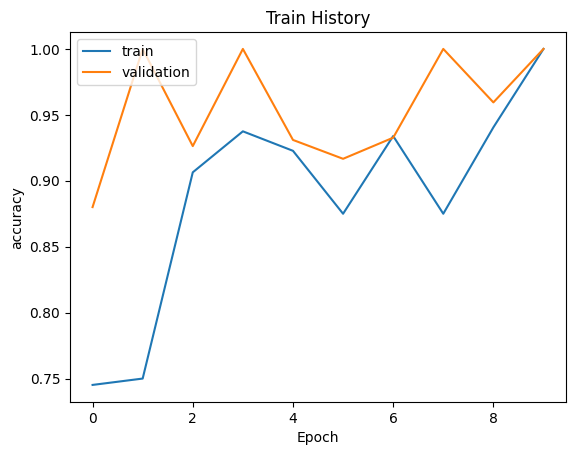

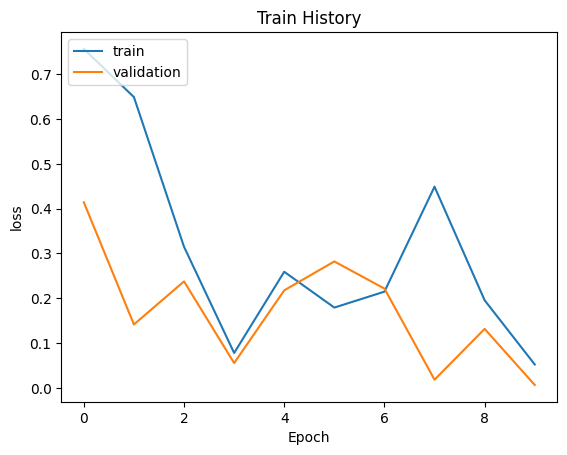

In [53]:
score=M7.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M7,'accuracy','val_accuracy')
show_train_history(train_history_M7,'loss','val_loss')

In [20]:
M7_pred_df=eval_model_by_class(M7, X_test)
M7_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'PermanentCropAnnualCropAnnualCropAnnualCropA...,1429,1500,0.952667,0.911778
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1478,1500,0.985333,0.911778
2,2,b'HerbaceousVegetation',b'PermanentCropPermanentCropPermanentCropPerma...,1070,1500,0.713333,0.911778
3,3,b'Highway',b'HerbaceousVegetationHighwayRiverHighwayRiver...,1055,1250,0.844000,0.911778
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1037,1250,0.829600,0.911778
5,5,b'Pasture',b'PermanentCropPasturePasturePasturePasturePas...,891,1000,0.891000,0.911778
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1189,1250,0.951200,0.911778
7,7,b'Residential',b'ResidentialResidentialResidentialResidential...,1496,1500,0.997333,0.911778
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1183,1250,0.946400,0.911778
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1481,1500,0.987333,0.911778


### **Part B. Model 8:** Try M7 again, but add `EarlyStopping()` and `ReduceLROnPlateau()` (Model 6+Data Augmentation+EarlyStopping+ReduceLRoNpLATEAU)

In [54]:
model_file='/content/drive/MyDrive/liu/Models/M8.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]

In [55]:
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
  def lr(y_true, y_pred):
    return optimizer.learning_rate
  return lr

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)

In [56]:
M8=Sequential()

conv_base=vgg16.VGG16(include_top=False, input_shape=input_shape)

M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

M8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True

In [63]:
M8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,306,720 (180.46 MB)

 Trainable params: 15,768,906 (60.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,537,814 (120.31 MB)

In [57]:
train_history_M8=M8.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5315 - loss: 1.2987 - lr: 1.0000e-04 - val_accuracy: 0.8528 - val_loss: 0.4502 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1797 - lr: 1.0000e-04 - val_accuracy: 0.9167 - val_loss: 0.3207 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8736 - loss: 0.4205 - lr: 1.0000e-04 - val_accuracy: 0.9301 - val_loss: 0.2392 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0357 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.1194 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9090 - loss: 0.2936 - lr: 1.0000e-04 - val_accuracy: 0.9190 - val_loss: 0.2874 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━

Test loss: 0.21096232533454895
Test accuracy: 0.9358518719673157


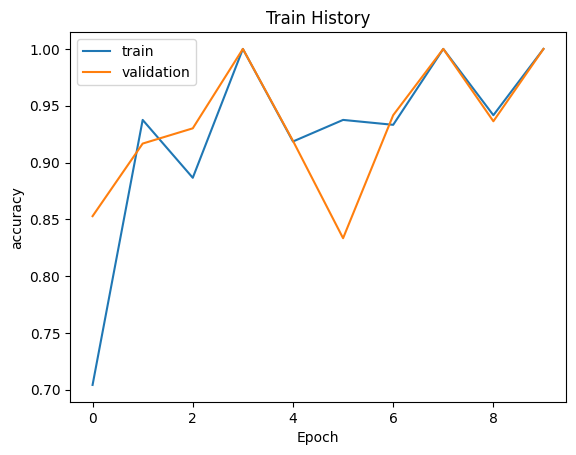

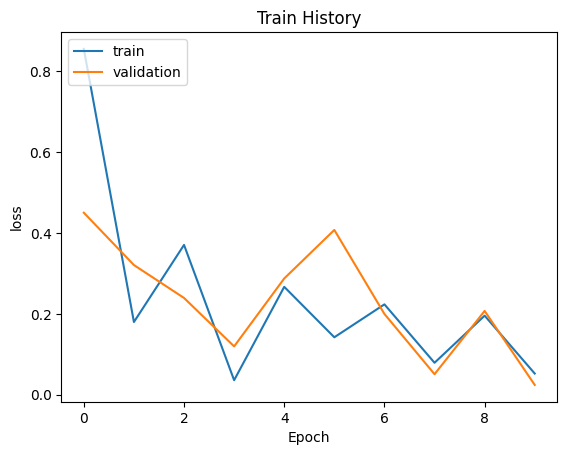

In [58]:
score=M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M8,'accuracy','val_accuracy')
show_train_history(train_history_M8,'loss','val_loss')

In [30]:
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


,index,y_true,y_pred,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',b'PermanentCropAnnualCropAnnualCropAnnualCropA...,1338,1500,0.892000,0.943704
1,1,b'Forest',b'ForestForestForestForestForestForestForestFo...,1487,1500,0.991333,0.943704
2,2,b'HerbaceousVegetation',b'HerbaceousVegetationPermanentCropHerbaceousV...,1391,1500,0.927333,0.943704
3,3,b'Highway',b'HighwayHighwayIndustrialHighwayRiverHighwayH...,1107,1250,0.885600,0.943704
4,4,b'Industrial',b'IndustrialIndustrialIndustrialIndustrialIndu...,1242,1250,0.993600,0.943704
5,5,b'Pasture',b'PermanentCropPasturePasturePasturePasturePas...,964,1000,0.964000,0.943704
6,6,b'PermanentCrop',b'PermanentCropPermanentCropPermanentCropPerma...,1091,1250,0.872800,0.943704
7,7,b'Residential',b'ResidentialResidentialIndustrialResidentialR...,1418,1500,0.945333,0.943704
8,8,b'River',b'RiverRiverRiverRiverRiverRiverRiverRiverRive...,1226,1250,0.980800,0.943704
9,9,b'SeaLake',b'SeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSeaLakeSe...,1476,1500,0.984000,0.943704


### **Dataframe with all results**

In [113]:
all_pred_df = M1_pred_df.loc[:, ['y_true', 'label_count']]
all_pred_df['M1_class_acc'] = M1_pred_df.loc[:, 'class_acc']
all_pred_df['M1_overall_acc'] = M1_pred_df.loc[:, 'overall_acc']

all_pred_df['M2_class_acc'] = M2_pred_df.loc[:, 'class_acc']
all_pred_df['M2_overall_acc'] = M2_pred_df.loc[:, 'overall_acc']

all_pred_df['M3_class_acc'] = M3_pred_df.loc[:, 'class_acc']
all_pred_df['M3_overall_acc'] = M3_pred_df.loc[:, 'overall_acc']

all_pred_df['M4_class_acc'] = M4_pred_df.loc[:, 'class_acc']
all_pred_df['M4_overall_acc'] = M4_pred_df.loc[:, 'overall_acc']

all_pred_df['M5_class_acc'] = M5_pred_df.loc[:, 'class_acc']
all_pred_df['M5_overall_acc'] = M5_pred_df.loc[:, 'overall_acc']

all_pred_df['M6_class_acc'] = M6_pred_df.loc[:, 'class_acc']
all_pred_df['M6_overall_acc'] = M6_pred_df.loc[:, 'overall_acc']

all_pred_df['M7_class_acc'] = M7_pred_df.loc[:, 'class_acc']
all_pred_df['M7_overall_acc'] = M7_pred_df.loc[:, 'overall_acc']

all_pred_df['M8_class_acc'] = M8_pred_df.loc[:, 'class_acc']
all_pred_df['M8_overall_acc'] = M8_pred_df.loc[:, 'overall_acc']

all_pred_df

,y_true,label_count,M1_class_acc,M1_overall_acc,M2_class_acc,M2_overall_acc,M3_class_acc,M3_overall_acc,M4_class_acc,M4_overall_acc,M5_class_acc,M5_overall_acc,M6_class_acc,M6_overall_acc,M7_class_acc,M7_overall_acc,M8_class_acc,M8_overall_acc
0,b'AnnualCrop',1500,0.009333,0.190667,0.578000,0.3,0.0,0.111111,0.782000,0.762,0.849333,0.867185,0.858000,0.921704,0.952667,0.911778,0.892000,0.943704
1,b'Forest',1500,0.010000,0.190667,0.744667,0.3,0.0,0.111111,0.902667,0.762,0.952000,0.867185,0.989333,0.921704,0.985333,0.911778,0.991333,0.943704
2,b'HerbaceousVegetation',1500,0.000000,0.190667,0.127333,0.3,0.0,0.111111,0.623333,0.762,0.725333,0.867185,0.884667,0.921704,0.713333,0.911778,0.927333,0.943704
3,b'Highway',1250,0.023200,0.190667,0.000000,0.3,0.0,0.111111,0.544000,0.762,0.814400,0.867185,0.908800,0.921704,0.844000,0.911778,0.885600,0.943704
4,b'Industrial',1250,0.677600,0.190667,0.681600,0.3,0.0,0.111111,0.950400,0.762,0.930400,0.867185,0.941600,0.921704,0.829600,0.911778,0.993600,0.943704
5,b'Pasture',1000,0.000000,0.190667,0.000000,0.3,0.0,0.111111,0.848000,0.762,0.929000,0.867185,0.943000,0.921704,0.891000,0.911778,0.964000,0.943704
6,b'PermanentCrop',1250,0.000800,0.190667,0.000000,0.3,0.0,0.111111,0.631200,0.762,0.816800,0.867185,0.803200,0.921704,0.951200,0.911778,0.872800,0.943704
7,b'Residential',1500,0.266000,0.190667,0.212000,0.3,1.0,0.111111,0.820667,0.762,0.957333,0.867185,0.995333,0.921704,0.997333,0.911778,0.945333,0.943704
8,b'River',1250,0.780000,0.190667,0.384000,0.3,0.0,0.111111,0.535200,0.762,0.740000,0.867185,0.914400,0.921704,0.946400,0.911778,0.980800,0.943704
9,b'SeaLake',1500,0.196000,0.190667,0.150000,0.3,0.0,0.111111,0.946667,0.762,0.950000,0.867185,0.966000,0.921704,0.987333,0.911778,0.984000,0.943704


from matplotlib import pyplot as plt
all_pred_df['label_count'].plot(kind='hist', bins=20, title='label_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df['M1_class_acc'].plot(kind='hist', bins=20, title='M1_class_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df['M2_class_acc'].plot(kind='hist', bins=20, title='M2_class_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df['M3_class_acc'].plot(kind='hist', bins=20, title='M3_class_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df.plot(kind='scatter', x='label_count', y='M1_class_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df.plot(kind='scatter', x='M1_class_acc', y='M2_class_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df.plot(kind='scatter', x='M2_class_acc', y='M3_class_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df.plot(kind='scatter', x='M3_class_acc', y='M4_class_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['M1_overall_acc']
  ys = series['label_count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = all_pred_df.sort_values('M1_overall_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('M1_overall_acc')
_ = plt.ylabel('label_count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['M1_overall_acc']
  ys = series['M1_class_acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = all_pred_df.sort_values('M1_overall_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('M1_overall_acc')
_ = plt.ylabel('M1_class_acc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['M1_overall_acc']
  ys = series['M2_class_acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = all_pred_df.sort_values('M1_overall_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('M1_overall_acc')
_ = plt.ylabel('M2_class_acc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['M1_overall_acc']
  ys = series['M3_class_acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = all_pred_df.sort_values('M1_overall_acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('M1_overall_acc')
_ = plt.ylabel('M3_class_acc')

from matplotlib import pyplot as plt
all_pred_df['label_count'].plot(kind='line', figsize=(8, 4), title='label_count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df['M1_class_acc'].plot(kind='line', figsize=(8, 4), title='M1_class_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df['M2_class_acc'].plot(kind='line', figsize=(8, 4), title='M2_class_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_pred_df['M3_class_acc'].plot(kind='line', figsize=(8, 4), title='M3_class_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

### **Part C. Your Model**

Based on the Model 1-8, develope a model to improve the classification results. The requirements are
1. Compare three different backborn models.
2. Improve the classification results as much as you can.

**Compare three different backborn models.**

EfficientNetB0

In [60]:
from tensorflow.keras.applications import EfficientNetB0

model_file='/content/drive/MyDrive/liu/Models/M9.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]

# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)

M9=Sequential()

conv_base=EfficientNetB0(include_top=False, input_shape=input_shape)

M9.add(conv_base)

M9.add(Flatten())
M9.add(Dropout(0.5))
M9.add(Dense(512, activation='relu'))
M9.add(Dense(num_classes, activation='softmax'))

M9.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True

M9.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 2, 2, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,676,653 (25.47 MB)

 Trainable params: 6,634,630 (25.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [61]:
train_history_M9=M9.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 117s 66ms/step - accuracy: 0.5964 - loss: 1.2658 - lr: 1.0000e-04 - val_accuracy: 0.6466 - val_loss: 2.8021 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.8750 - loss: 0.5233 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8750 - loss: 0.5233 - lr: 1.0000e-04 - val_accuracy: 0.5833 - val_loss: 1.2620 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8372 - loss: 0.5016 - lr: 1.0000e-04 - val_accuracy: 0.9272 - val_loss: 0.2275 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 0.7502 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0075 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.8751 - loss: 0.3833 - lr: 1.0000e-04 - val_accuracy: 0.9336 - val_loss: 0.1981 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.9375 - loss: 0.0987 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0848 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━

Test loss: 0.22684422135353088
Test accuracy: 0.9277036786079407


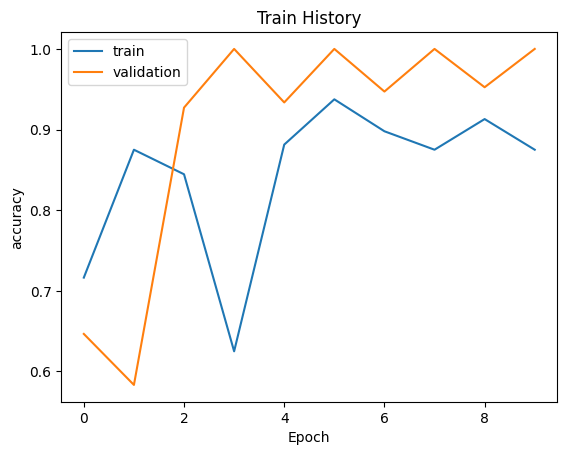

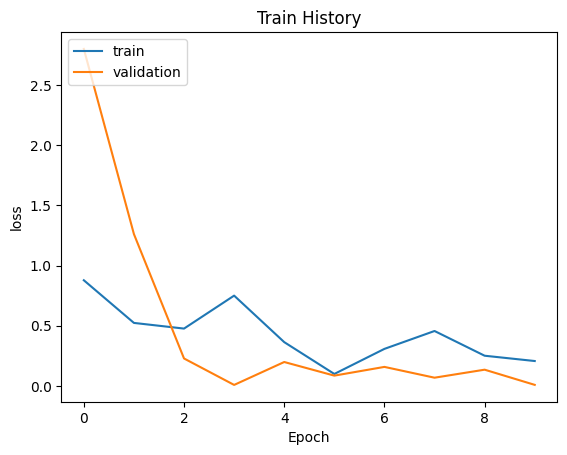

In [62]:
score=M9.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M9,'accuracy','val_accuracy')
show_train_history(train_history_M9,'loss','val_loss')

ResNet50

In [64]:
from tensorflow.keras.applications import ResNet50

model_file='/content/drive/MyDrive/liu/Models/M10.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]

# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)

M10=Sequential()

conv_base=ResNet50(include_top=False, input_shape=input_shape)

M10.add(conv_base)

M10.add(Flatten())
M10.add(Dropout(0.5))
M10.add(Dense(512, activation='relu'))
M10.add(Dense(num_classes, activation='softmax'))

M10.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True

M10.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,787,658 (106.00 MB)

 Trainable params: 27,734,538 (105.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [65]:
train_history_M10=M10.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 98s 57ms/step - accuracy: 0.6856 - loss: 1.1517 - lr: 1.0000e-04 - val_accuracy: 0.4310 - val_loss: 2.3149 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.8750 - loss: 0.4088 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8750 - loss: 0.4088 - lr: 1.0000e-04 - val_accuracy: 0.5000 - val_loss: 1.4971 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8810 - loss: 0.3797 - lr: 1.0000e-04 - val_accuracy: 0.9342 - val_loss: 0.2296 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.5984 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0098 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9103 - loss: 0.2839 - lr: 1.0000e-04 - val_accuracy: 0.9555 - val_loss: 0.1381 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.9375 - loss: 0.2110 - lr: 1.0000e-04 - val_accuracy: 1.0000 - val_loss: 0.0365 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━━━━━

Test loss: 0.22715990245342255
Test accuracy: 0.934592604637146


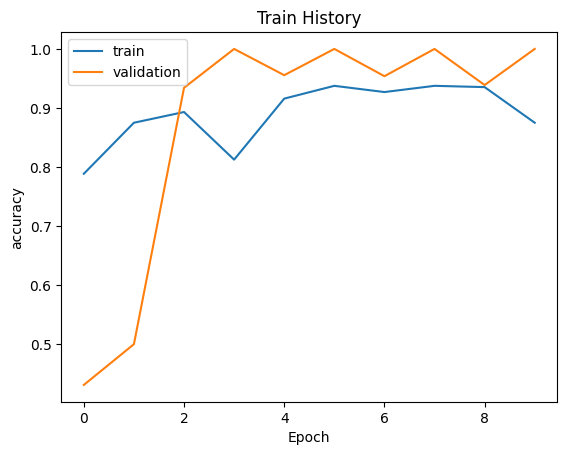

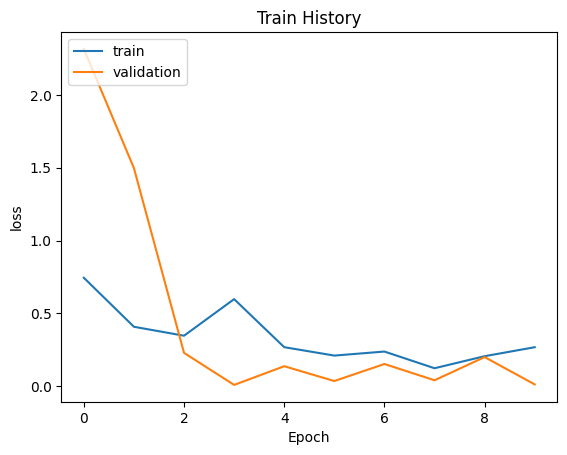

In [66]:
score=M10.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M10,'accuracy','val_accuracy')
show_train_history(train_history_M10,'loss','val_loss')

NASNetLarge

In [67]:
from tensorflow.keras.applications import NASNetLarge

model_file='/content/drive/MyDrive/liu/Models/M11.h5.keras'

early_stop=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', # what is the metric to measure
                          patience=15, # how many epochs to continue running the model after seeing an increase in val_loss
                          restore_best_weights=True) # update the model with the best-seen weights?

reduce_LR=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=5) # to make sure early_stop is what stops the model

checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_file,
                          monitor='val_loss',
                          save_best_only=True)

callback_list=[reduce_LR, early_stop, checkpoint]

# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009

optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)

M11=Sequential()

conv_base=NASNetLarge(include_top=False, input_shape=input_shape)

M11.add(conv_base)

M11.add(Flatten())
M11.add(Dropout(0.5))
M11.add(Dense(512, activation='relu'))
M11.add(Dense(num_classes, activation='softmax'))

M11.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

for layer in conv_base.layers[7:]:
  layer.trainable = True

M11.summary()

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ nasnet_large (Functional)            │ (None, 2, 2, 4032)          │      84,916,818 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 16128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │       8,258,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,179,996 (355.45 MB)

 Trainable params: 92,983,328 (354.70 MB)

 Non-trainable params: 196,668 (768.23 KB)

In [68]:
train_history_M11=M11.fit(train_generator,
            steps_per_epoch=len(X_train)//batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=len(X_test)//batch_size,
            callbacks=callback_list)

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 547s 278ms/step - accuracy: 0.6091 - loss: 1.1971 - lr: 1.0000e-04 - val_accuracy: 0.6204 - val_loss: 1.3204 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 1:51 132ms/step - accuracy: 0.9375 - loss: 0.1680 - lr: 1.0000e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


843/843 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9375 - loss: 0.1680 - lr: 1.0000e-04 - val_accuracy: 0.5833 - val_loss: 1.4874 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 94s 111ms/step - accuracy: 0.8755 - loss: 0.3994 - lr: 1.0000e-04 - val_accuracy: 0.6959 - val_loss: 1.4610 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 1.0000 - loss: 0.0105 - lr: 1.0000e-04 - val_accuracy: 0.5833 - val_loss: 1.0840 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 103s 123ms/step - accuracy: 0.9141 - loss: 0.2752 - lr: 1.0000e-04 - val_accuracy: 0.8602 - val_loss: 0.4792 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 1.0000 - loss: 0.1121 - lr: 1.0000e-04 - val_accuracy: 0.8333 - val_loss: 0.5394 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 7/10
843/843 ━━━━━━━━━━━━━

Test loss: 0.7869390249252319
Test accuracy: 0.7968888878822327


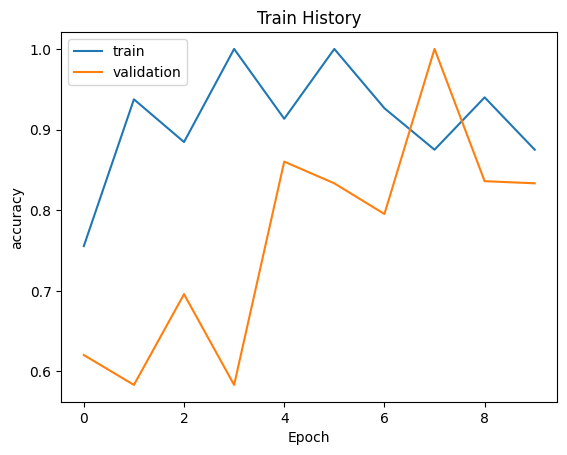

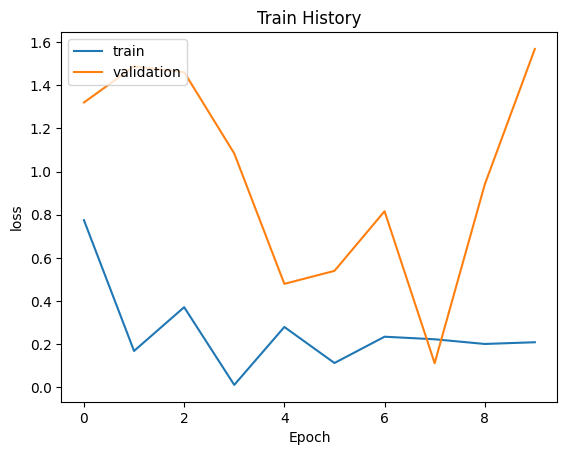

In [69]:
score=M11.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(train_history_M11,'accuracy','val_accuracy')
show_train_history(train_history_M11,'loss','val_loss')

**Improve the classification results as much as you can.**

In [82]:
# ======================== Modified Section =========================
# Import additional modules for enhancements
from tensorflow.keras.applications import EfficientNetB0  # Modern architecture for transfer learning

model_file='/content/drive/MyDrive/liu/Models/model.h5.keras'

# ======================== Pretrained Model Setup =========================
# Use EfficientNetB0 with pretrained ImageNet weights
base_model = EfficientNetB0(include_top=False, input_shape=input_shape)


# Add custom classification head
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),  # Increased hidden layer size for better feature extraction
    Dropout(0.5),                   # Added dropout for regularization
    Dense(len(label_names), activation='softmax')  # Number of classes from dataset
])

# ======================== Compile Model =========================
# Use Adam optimizer with a learning rate scheduler
optimizer=Adam(learning_rate=1e-4)
lr_metric=get_lr_metric(optimizer)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', lr_metric])

# ======================== Data Augmentation =========================
# Improved data augmentation strategies

data_gen = ImageDataGenerator(
    #rescale=1. / 255,
    rotation_range=15,   # Rotate images up to 15 degrees
    shear_range=0.2,        # Shearing transformation
    zoom_range=0.2,         # Zoom in/out by 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True
)

# Augment training data
train_gen = data_gen.flow(X_train, y_train, batch_size=batch_size, seed=42)
val_gen = data_gen.flow(X_test, y_test, batch_size=batch_size, seed=42)
'''
train_datagen=ImageDataGenerator(
    # rescale=1. / 255,
#    shear_range=0.2,
#    zoom_range=0.2,
#    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen=ImageDataGenerator()

train_generator=train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    seed=42)

test_generator=test_datagen.flow(
    X_test,
    y_test,
    batch_size=batch_size,
    seed=42)
'''
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 2, 2, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,363,117 (20.46 MB)

 Trainable params: 5,321,094 (20.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [83]:
# ======================== Train Model =========================
# Increase epochs for better convergence
history_model = model.fit(train_gen,
              steps_per_epoch=len(X_train)//batch_size,
              validation_data=val_gen,
              epochs=15,
              validation_steps=len(X_test)//batch_size,
              callbacks=callback_list)

Epoch 1/15
843/843 ━━━━━━━━━━━━━━━━━━━━ 129s 82ms/step - accuracy: 0.5364 - loss: 1.4470 - lr: 1.0000e-04 - val_accuracy: 0.6370 - val_loss: 3.0014 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 2/15
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8125 - loss: 0.4273 - lr: 1.0000e-04 - val_accuracy: 0.5833 - val_loss: 3.3444 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 3/15
843/843 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.8186 - loss: 0.5629 - lr: 1.0000e-04 - val_accuracy: 0.9201 - val_loss: 0.2454 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 4/15
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.8750 - loss: 0.4109 - lr: 1.0000e-04 - val_accuracy: 0.8333 - val_loss: 0.6109 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 5/15
843/843 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.8597 - loss: 0.4350 - lr: 1.0000e-04 - val_accuracy: 0.9395 - val_loss: 0.1851 - val_lr: 1.0000e-04 - learning_rate: 1.0000e-04
Epoch 6/15
843/843 ━━━

Test loss: 0.1822376847267151
Test accuracy: 0.9394814968109131


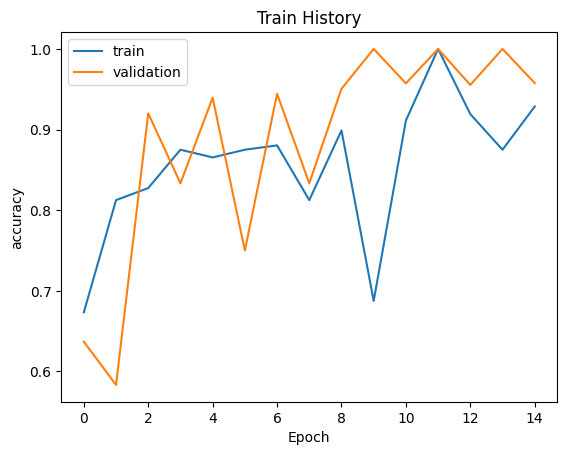

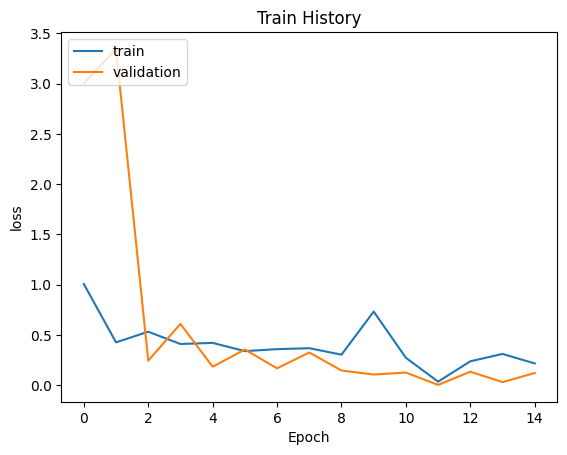

In [84]:
score=model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

show_train_history(history_model,'accuracy','val_accuracy')
show_train_history(history_model,'loss','val_loss')